In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim.models.word2vec import Word2Vec
import prince
from tqdm import tqdm
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import rcParams
from matplotlib import pyplot as plt
from itertools import combinations
import networkx as nx
import re
from collections import Counter
import random
import math
from colormap import rgb2hex
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from adjustText import adjust_text
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) 

In [2]:
# some functions
def most_common(df,column,n):
    ls=df.groupby(str(column)).Year.count().to_frame().sort_values(by='Year',ascending=False).index.to_list()[:n]
    return ls
index_ds={'2': 'engineering and technology','1':'natural sciences', '5':'social sciences', '3':'medical and health sciences','6':'humanities', '4':'agricultural sciences'}
def method_ds(df, i):
    cs=df[df['keywords']==i].explode('Method_detect')
    top_50=cs.groupby('Method_detect').Method_detect.count().reset_index(name='count').sort_values(['count'], ascending=False) \
                                 .head(20).Method_detect.to_list()
    return cs[cs.Method_detect.isin(top_50)]


In [3]:
# read files
data=pd.read_csv('./data_10_20.csv')
method =pd.read_excel("Methods_raw.xlsx")
method_1=method.dropna(subset=['Method'])
methods_list=method_1[method_1.Method==1.0].reset_index(drop=True).Methods_raw.to_list()
method_full=method.Methods_raw.to_list()

In [4]:
# remove the lower-level method terms
method_2=methods_list.copy()
remove=[]
while len(method_2)>0:
    i= method_2.pop(0)
    for j in methods_list:
        if j in i and j != i:
            remove.append(i)
method_2=[item for item in methods_list if item not in remove]

In [5]:
len(method_2)

106

In [6]:
# method embedding
w2v = Word2Vec.load("word2vec_1202_count1.model")
my_dict = dict({})
for idx, key in enumerate(method_2):
    try:
        my_dict[key] = w2v.wv[key.replace(' ','-')]
    except:
        pass

**Method detection**

In [7]:
for i in tqdm(range(len(data))):
    x=eval(data.loc[i, "docs"])
    data.at[i,'Method_detect']=list(set([s for s in method_2 if s in " ".join(x)]))

100%|██████████| 11909/11909 [00:06<00:00, 1966.36it/s]


In [10]:
# missing data
data2=data[data['Method_detect'].str.len() !=0].reset_index(drop=True)
method_1=[j for i in data2.Method_detect if len(i) >=1 for j in list(set(i))]
method_detect=data2.Method_detect.to_list().copy()
print("method detect number: ", len(data2),", " ,"method detect percentage: ", np.round(len(data2)/len(data), 2))

method detect number:  7183 ,  method detect percentage:  0.6


In [22]:
data2.sample(10).to_csv('sensitivity_check.csv', index=False)

In [63]:
data2.Method_detect[2]

['anova', 'natural-language-processing']

**Results visualization**

In [21]:
# find the most mentioned terms
method_dict=pd.DataFrame(method_1)
method_dict.columns=['method']
top_50=method_dict.groupby('method').method.count().reset_index(name='count').sort_values(['count'], ascending=False) \
                             .head(15).method.to_list()
# color palette from Colorgorical, see http://vrl.cs.brown.edu/color for details
copy_colormap=["rgb(64,101,94)", "rgb(119,209,253)", "rgb(85,110,222)", "rgb(228,204,241)", "rgb(140,13,164)", "rgb(246,127,236)", "rgb(4,138,209)", "rgb(30,239,201)", "rgb(42,150,86)", "rgb(127,220,100)", "rgb(115,53,24)", "rgb(187,207,122)", "rgb(230,38,47)", "rgb(209,100,54)", "rgb(250,186,114)"]
def colorgorical(copy_colormap):
    colors=[eval(i[3:]) for i in copy_colormap]
    transform = [rgb2hex(colors[i][0],colors[i][1],colors[i][2]) for i in range(len(colors))]
    return transform 
colors=colorgorical(copy_colormap)

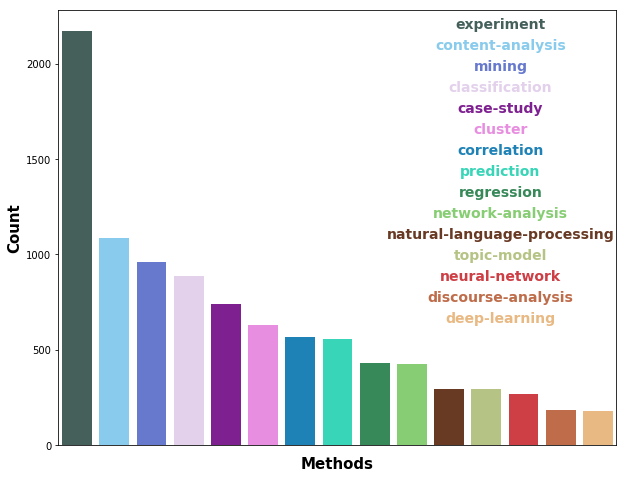

In [18]:
#visualization
class TextHandler(HandlerBase):
    def create_artists(self, legend, tup ,xdescent, ydescent,
                        width, height, fontsize,trans):
        tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                  ha="center", va="center", color=tup[1], fontweight="bold")
        return [tx]
handltext = top_50
labels = ['' for i in top_50]
method_dict=method_dict[method_dict.method.isin(top_50)]

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,8) ) 
ax = sns.countplot(x=method_dict['method'], order=top_50, palette=colors)
t = ax.get_xticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()]  for h in t]
handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,ax.patches)]

leg=ax.legend(handles, labels, handler_map={tuple : TextHandler()}, bbox_to_anchor=(0.86, 1.01),  prop={'size': 14}) 
leg.get_frame().set_edgecolor('b')
leg.get_frame().set_linewidth(0.0)
ax.set_xticklabels('', rotation=40, ha="right")
ax.tick_params(bottom=False) 
plt.ylabel('Count', fontsize=15,fontweight='bold')
plt.xlabel('Methods', fontsize=15,fontweight='bold')

fig.savefig('count.png')

**Development over time**

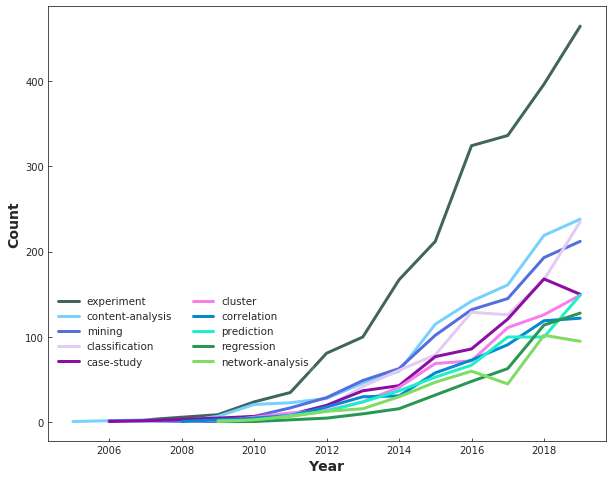

In [69]:
for i in data2[data2.Year==2020.0].index: #early access
    data2.loc[i,'Year']=2019.0
data3=data2.dropna(subset=['Year']).explode("Method_detect").reset_index(drop=True)
ls=most_common(data3,'Method_detect',10)
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,8) ) 
for i in range(len(ls)):
    sns.set_style("ticks")
    sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
    data_method_1=data3[data3['Method_detect'] == ls[i]].groupby('Year').Method_detect.count().reset_index()
    plt.plot(data_method_1.Year.to_numpy(), data_method_1.Method_detect.to_numpy(), label=ls[i], color=colors[i], linewidth = 3)
#handles, labels= ax.get_legend_handles_labels()
#labels, handles = labels[::-1], handles[::-1]
legend=plt.legend(ncol=2, loc="lower left", bbox_to_anchor=(0.002, 0.15),prop={'size': 10.3})
legend.get_frame().set_edgecolor('white')
legend.get_frame().set_alpha(0.1)
plt.ylabel('Count', fontsize=14,fontweight='bold')
plt.xlabel('Year', fontsize=14,fontweight='bold')
plt.xticks( fontsize=10)
plt.yticks( fontsize=10)
plt.show()
#fig.savefig('development.png',bbox_extra_artists=(legend,), bbox_inches='tight')

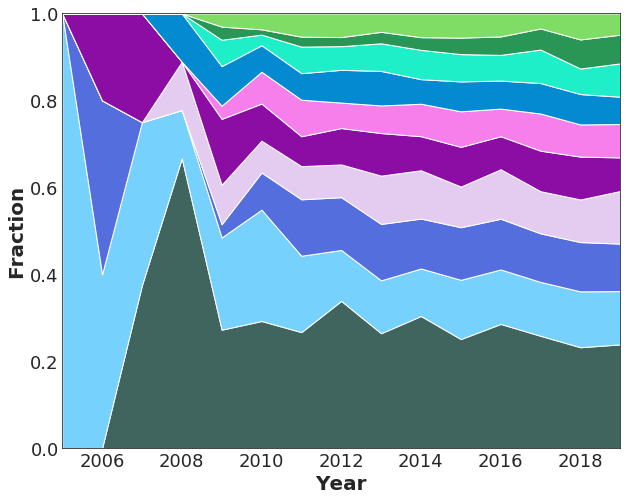

In [82]:
# Make the plot
data4=data3[data3.Method_detect.isin(ls)]
df_1=pd.crosstab(data4.Year, data4.Method_detect, normalize='index')
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,8) ) 
plt.stackplot(df_1.index,  [df_1[i] for i in ls], colors=colors)
plt.ylabel('Fraction', fontsize=20,fontweight='bold')
plt.xlabel('Year', fontsize=20,fontweight='bold')
plt.xticks( fontsize=18)
plt.yticks( fontsize=18)
plt.xlim(2005,2019)
plt.ylim(0,1)
fig.savefig('stacked_area.png')

**PCA**

In [8]:
pca = prince.PCA(
...     n_components=10,
...     n_iter=10,
...     rescale_with_mean=True,
...     rescale_with_std=True,
...     copy=True,
...     check_input=True,
...     engine='auto',
...     random_state=42
... )

In [11]:
data3=data2.explode('Method_detect').reset_index(drop=True)
ls=most_common(data3,'Method_detect',50)
indexxx=[list(my_dict.keys()).index(i) for i in ls]
X=np.array([i for i in my_dict.values()])[indexxx]
pca = pca.fit(X)

In [19]:
pca.explained_inertia_[:2]

array([0.18426818, 0.09435768], dtype=float32)

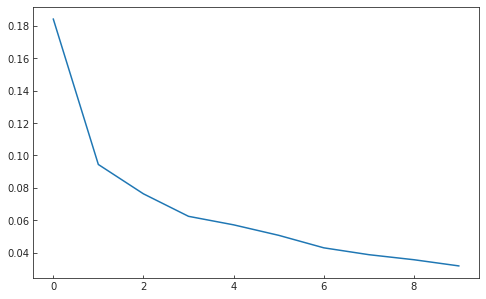

In [71]:
rcParams['figure.figsize'] = 8,5
plt.plot(pca.explained_inertia_)
plt.show()

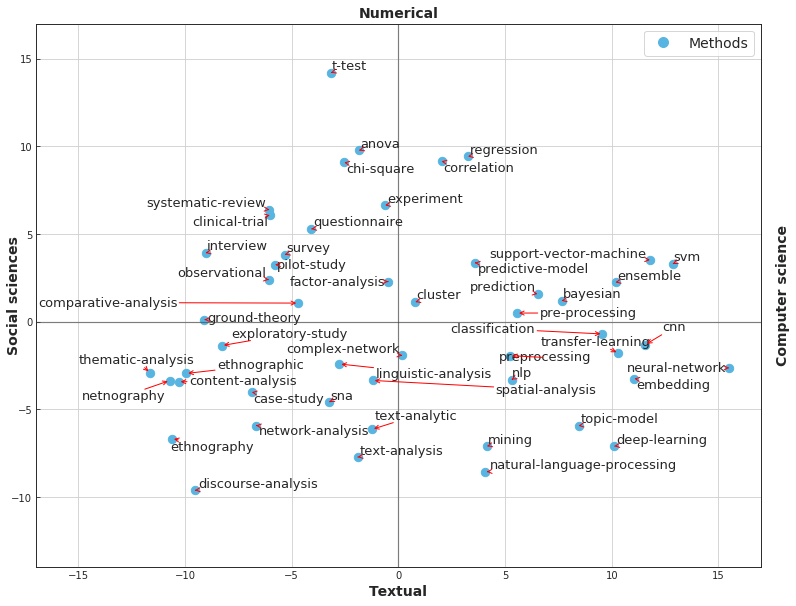

In [62]:
# visualization
rcParams['figure.figsize'] = 13,10
fig, ax = plt.subplots(figsize=(13, 10))
pca.plot_row_coordinates(X,ax=ax,x_component=0,y_component=1)
ROWS=pca.row_coordinates(X).to_dict()
XROWS=ROWS[0]
YROWS=ROWS[1]
XGLOBAL={ k : XROWS.get(k,0) for k in set(XROWS) }
YGLOBAL={ k : YROWS.get(k,0) for k in set(YROWS) }
plt.xlim(-17,17)
plt.ylim(-14,17)
texts=[plt.text(XGLOBAL[x],YGLOBAL[x],np.array([i for i in my_dict.keys()])[indexxx][x],fontsize=13) for x in XGLOBAL.keys()]
adjust_text(texts, only_move={'points':'x', 'texts':'x'}, arrowprops=dict(arrowstyle="->", color='r', lw=1))  
plt.gca().legend_.remove()
ax.scatter( XGLOBAL.values(), YGLOBAL.values(), lw=1, s=70, color="#58b5e1")
plt.title('Numerical', fontsize=14,fontweight='bold')
ax.set_xlabel('Textual', fontsize=14,fontweight='bold')
ax.set_ylabel('Social sciences', fontsize=14,fontweight='bold')
ax.yaxis.set_label_coords(-0.02, 0.5)
ax2 = ax.twinx()
ax2.set_ylabel('Computer science', fontsize=14,fontweight='bold')
ax2.yaxis.set_label_coords(1.02, 0.5)
ax2.set_yticks([])
h = [plt.plot([],[], color="#58b5e1", marker="o", ms=10, ls="")[0]]
plt.legend(handles=h, labels=["Methods"], fontsize=14)
plt.show()
#ax.legend(["Method"])
#ax.grid(False)

In [316]:
fig.savefig('pca.png')

**Heatmap**

In [12]:
from numpy.linalg import norm
from numpy import dot
def similarity(w,v):
    sim=dot(w, v)/(norm(w)*norm(v))
    return sim
similarity_scores=np.zeros(shape=(40,40))
for i in range(40):
    for j in range(40):
        similarity_scores[i,j]=similarity(my_dict[ls[i]],my_dict[ls[j]])

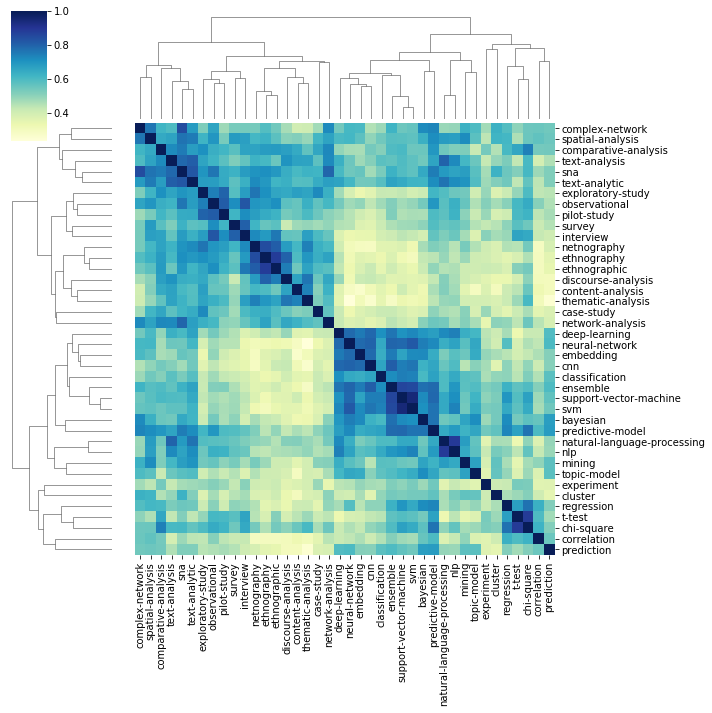

In [17]:
data=pd.DataFrame(similarity_scores, columns=ls[:40], index=ls[:40])
ax = sns.clustermap(data, cmap="YlGnBu", yticklabels=True, xticklabels=True)

**Mapping the embedding space**

In [33]:
# word vectors
#the number of unique terms after preprocessing
articles = [eval(i)[:-1] for i in data['docs'].copy()]
term=[]
for i in range(11909):
    term+=articles[i]
terms=[i for i, j in dict(Counter(term)).items() if j >=10]
#get the word vector
my_dict = dict({})
for idx, key in enumerate(terms):
    try:
        my_dict[key] = w2v.wv[key.replace(' ','-')]
    except:
        pass

tokens=np.array([i for i,j in my_dict.items() if len(i)>3 or i in method_2])
X=np.array([j for i,j in my_dict.items() if len(i)>3 or i in method_2])

In [47]:
# tsne plot
RS = 8888
def tsne_plot(X):
    X=np.array(X)
    pca = PCA(n_components=50)
    X_pca=pca.fit_transform(X)
    proj = TSNE(metric='cosine',square_distances=True).fit_transform(X_pca)
    return proj
proj=tsne_plot(X)

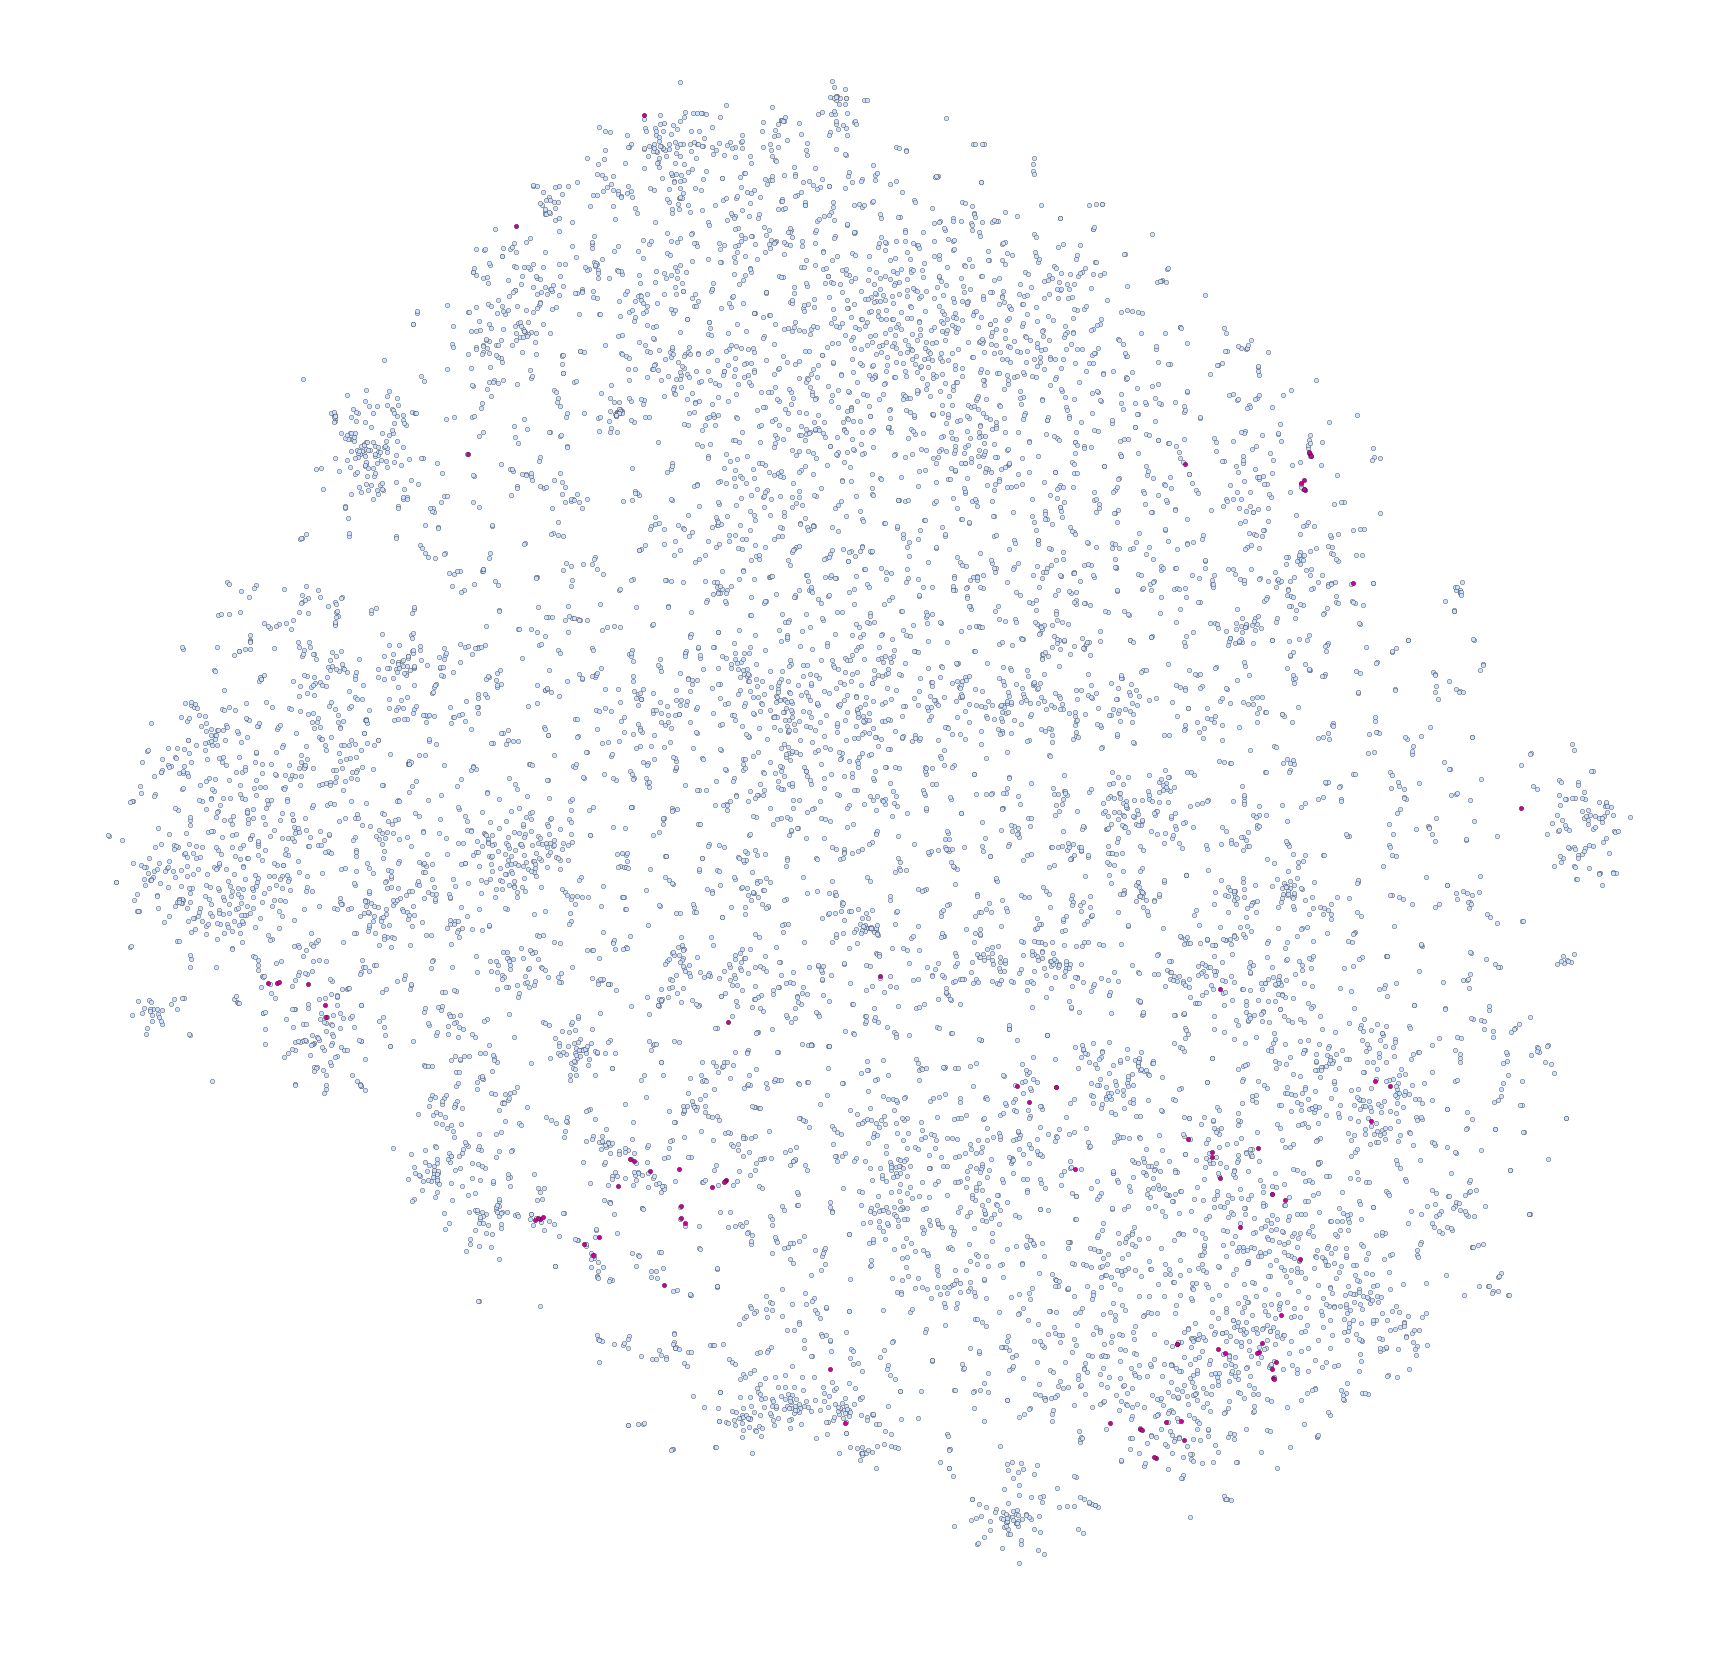

In [49]:
rcParams['figure.figsize'] = 30,30
x=proj
fig, ax= plt.subplots()
palette = ["#CCE0FF","#cc0099" ]
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
idx = [i for i,key in enumerate(tokens) if key in method_2 ]
y=np.zeros(len(tokens))
y=np.array([1 if i in idx else 0 for i, j in enumerate(y)])
for i in range(len(set(y))):
    ax.scatter(x[y==i,0], x[y==i,1], lw=0.3, s=20, edgecolors='black',c=palette[i])
    ax.axis('off')
    ax.axis('tight')
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
#colors = np.array(sns.color_palette("hls", len(set(labels))))[np.newaxis, :, :]
#legend_properties = {'weight':'bold'}
#plt.legend(ncol=1,prop=legend_properties)
plt.show()